In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import torch

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Wed Nov  1 12:55:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from pycocotools import coco

In [ ]:
from torchvision.datasets import VisionDataset
import os
import torch
import torchvision
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import albumentations as A
from albumentations.pytorch import ToTensorV2
import sys

In [ ]:
train_coco = coco.COCO('/content/gdrive/MyDrive/chess_training/train/_annotations.coco.json')

loading annotations into memory...
Done (t=1.98s)
creating index...
index created!


In [ ]:
categories = [cat['name'] for cat in train_coco.cats.values()]

In [ ]:
n_classes = len(categories)

In [ ]:
train_coco.loadAnns(train_coco.getAnnIds(0))

[{'id': 0,
  'image_id': 0,
  'category_id': 7,
  'bbox': [1643, 896, 156, 209],
  'area': 32604,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 1,
  'image_id': 0,
  'category_id': 5,
  'bbox': [1010, 10, 106, 145],
  'area': 15370,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 2,
  'image_id': 0,
  'category_id': 3,
  'bbox': [1531, 364, 173, 285],
  'area': 49305,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 3,
  'image_id': 0,
  'category_id': 6,
  'bbox': [1154, 276, 138, 246],
  'area': 33948,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 4,
  'image_id': 0,
  'category_id': 5,
  'bbox': [1372, 486, 120, 138],
  'area': 16560,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 5,
  'image_id': 0,
  'category_id': 5,
  'bbox': [1327, 247, 114, 136],
  'area': 15504,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 6,
  'image_id': 0,
  'category_id': 5,
  'bbox': [1311, 127, 98, 143],
  'area': 14014,
  'segmentation': [],
  'iscrowd': 0},
 {'id': 7,
  'image_id': 0,
  'category_id'

In [ ]:
def transform_image(split):
  if split == 'train':
    transform = A.Compose([
        A.Resize(1300, 2000),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomBrightness(),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='coco'))
  else:
    transform = A.Compose([
        A.Resize(1300, 2000),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='coco'))
  return transform

In [ ]:
class ChessDataset(VisionDataset):
  def __init__(self, root, split, transform=None, transforms=None, target_transform=None):
    super().__init__(root, transforms, transform, target_transform)
    self.root = root
    self.split = split
    self.coco = coco.COCO(os.path.join(self.root, self.split, '_annotations.coco.json'))
    self.ids = [value['id'] for value in self.coco.anns.values()]

    #some images contain more than one annotation so we are deleting ids where there is no anns
    self.ids = [id for id in self.ids if len(self.coco.loadAnns(self.coco.getAnnIds(id))) > 0]

    self.transforms = transforms

  def load_image(self, id):
    image_filename = self.coco.imgs[id]['file_name']
    self.image = cv2.imread(os.path.join(self.root, self.split, image_filename))
    return self.image

  def __len__(self):
    return len(self.ids)

  def __getitem__(self, index):
    id = self.ids[index]
    image = self.load_image(id)
    target = self.coco.loadAnns(self.coco.getAnnIds(id))
    target = deepcopy(target)

    bboxes = [t['bbox'] + [t['category_id']] for t in target]

    if self.transforms is not None:
      transformed = self.transforms(image=image, bboxes=bboxes)

    image = transformed['image']
    bboxes = transformed['bboxes']

    new_boxes = []
    for box in bboxes:
      x_min = box[0]
      y_min = box[1]
      x_max = x_min + box[2]
      y_max = y_min + box[3]

      new_boxes.append([x_min, y_min, x_max, y_max])

    final_target = {}
    final_target['boxes'] = torch.tensor(new_boxes, dtype=torch.float32)
    final_target['labels'] = torch.tensor([value['category_id'] for value in self.coco.loadAnns(self.coco.getAnnIds(id))], dtype=torch.int64)
    # final_target['image_id'] = torch.tensor([value['image_id'] for value in train_coco.loadAnns(train_coco.getAnnIds(id))], dtype=torch.int64)
    # final_target['area'] = torch.tensor([value['area'] for value in train_coco.loadAnns(train_coco.getAnnIds(id))], dtype=torch.int64)
    # final_target['iscrowd'] = torch.tensor([value['iscrowd'] for value in train_coco.loadAnns(train_coco.getAnnIds(id))], dtype=torch.int64)

    return image.div(255.), final_target



NameError: ignored

In [ ]:
train_data = ChessDataset('/content/gdrive/MyDrive/chess_training', 'train', transforms=transform_image('train'))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [ ]:
test_data = ChessDataset('/content/gdrive/MyDrive/chess_training', 'test', transforms=transform_image('test'))

loading annotations into memory...
Done (t=1.06s)
creating index...
index created!


In [ ]:
model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:02<00:00, 35.9MB/s]


In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [ ]:
# testing if it works fine
images, targets = next(iter(train_loader))
images = [image for image in images]
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets)

In [ ]:
device = torch.device('cuda')

In [ ]:
torch.cuda.is_available()

True

In [ ]:
model = model.to(device)

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.0001)

In [ ]:
from tqdm import tqdm

In [ ]:
def training(model, loader, optimizer, device):
  model.train()

  all_losses = []
  all_losses_dict = []

  for images, targets in tqdm(loader):
      images = list(image.to(device) for image in images)
      targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

      loss_dict = model(images, targets) # the model computes the loss automatically if we pass in targets
      losses = sum(loss for loss in loss_dict.values())
      loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
      loss_value = losses.item()

      all_losses.append(loss_value)
      all_losses_dict.append(loss_dict_append)

      optimizer.zero_grad()
      losses.backward()
      optimizer.step()
  return all_losses

In [ ]:
epochs = 10
all_losses = []
for epoch in range(epochs):
  print(f'Training epoch: {epoch}')
  loss = training(model, train_loader, optimizer, device)
  all_losses.append(loss)

Training epoch: 0


  0%|          | 0/26 [00:00<?, ?it/s]<ipython-input-21-fb59cb11a3a3>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]
100%|██████████| 26/26 [03:30<00:00,  8.11s/it]


Training epoch: 1


100%|██████████| 26/26 [00:19<00:00,  1.35it/s]


Training epoch: 2


100%|██████████| 26/26 [00:20<00:00,  1.27it/s]


Training epoch: 3


100%|██████████| 26/26 [00:19<00:00,  1.36it/s]


Training epoch: 4


100%|██████████| 26/26 [00:19<00:00,  1.31it/s]


Training epoch: 5


100%|██████████| 26/26 [00:19<00:00,  1.31it/s]


Training epoch: 6


100%|██████████| 26/26 [00:19<00:00,  1.35it/s]


Training epoch: 7


100%|██████████| 26/26 [00:20<00:00,  1.27it/s]


Training epoch: 8


100%|██████████| 26/26 [00:19<00:00,  1.37it/s]


Training epoch: 9


100%|██████████| 26/26 [00:19<00:00,  1.32it/s]


In [ ]:
model.eval()
torch.cuda.empty_cache()

In [ ]:
import random

In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib

In [ ]:
prediction_bound = 0.7

In [ ]:
img, _ = test_data[random.randint(0, 25)] # take one image
img_int = torch.tensor(img*255, dtype=torch.uint8) # convert it to tensor
with torch.no_grad():
    prediction = model([img.to(device)])

<ipython-input-27-caf1aa130b8a>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img_int = torch.tensor(img*255, dtype=torch.uint8) # convert it to tensor


In [ ]:
pred = prediction[0]

In [ ]:
bboxes = [[box[0], box[1], box[2]-box[0], box[3]-box[1]] for box in pred['boxes'][pred['scores'] > prediction_bound]]

In [ ]:
predictions = pred['labels'][pred['scores'] > prediction_bound]

In [ ]:
fig, ax = plt.subplots()
# plt.imshow(torchvision.utils.draw_bounding_boxes(img_int, pred['boxes'][pred['scores'] > prediction_bound]).permute(1, 2, 0))
ax.imshow(img_int.permute(1, 2, 0))
for i, box in enumerate(bboxes):
  ax.add_patch(matplotlib.patches.Rectangle((box[0].item(), box[1].item()), box[2].item(), box[3].item(), fill=False))
  plt.text(box[0].item(), box[1].item(), categories[pred['labels'][pred['scores'] > prediction_bound][i].item()], fontsize='xx-small', color='red')

NameError: ignored

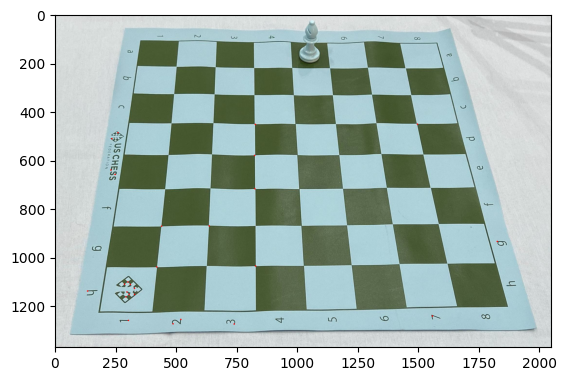

(<matplotlib.image.AxesImage at 0x7c4ca81258a0>, None)

In [ ]:
img = cv2.imread('/content/gdrive/MyDrive/chess_training/test/0b47311f426ff926578c9d738d683e76_jpg.rf.999ad103e4382fd86b69052c2c35b46e.jpg')

# convert image to gray scale image
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# detect corners with the goodFeaturesToTrack function.
corners = cv2.goodFeaturesToTrack(gray, 27, 0.01, 10)
corners = np.int0(corners)

# we iterate through each corner,
# making a circle at each point that we think is a corner.
for i in corners:
    x, y = i.ravel()
    cv2.circle(img, (x, y), 3, 255, -1)

plt.imshow(img), plt.show()

In [ ]:
torch.save(model, '/content/model')